**Notebook dédié à:** 

* l'analyse textuelle des abstracts
* la contruction de la matrice Document-Termes (Bag Of Words) 
* la construction de la matrice TF-IDF
* l'entrainement des modèles Kmeans et spherical kmeans sur ces deux matrices. 

# Importer les librairies 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.cluster import KMeans
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy import  sparse
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix


In [ ]:
pip install coclust

  Created wheel for coclust: filename=coclust-0.2.1-py3-none-any.whl size=29870 sha256=d520f3f971921143d7e5272e1a4dbb9e127fa055aaa8e55a04accb887c0701be
  Stored in directory: /root/.cache/pip/wheels/78/e9/dc/3f80429511bb4aa68ebf39a0f141661230809490d53557ce4a
Successfully built coclust


In [ ]:
import coclust

from coclust.clustering import SphericalKmeans


# Importer les données 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DF=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DBLP_Subset_processed.txt')

In [ ]:
abstract_lemmatized = DF['Abstract']

# Matrice Document-Terme ( Bag Of Words)

In [ ]:
#BOW Vectorizer 
vectorizer = CountVectorizer(max_features=1000)
DocTerm_abstract = vectorizer.fit_transform(abstract_lemmatized)
#print('DocTerm_text ', type(DocTerm_text))

#DocTerm_abstract=csr_matrix(DocTerm_abstract)
#DocTerm_abstract = DocTerm_abstract.tocsr()


#convertir la matrice sparse en matrice dense
DocTerm_abstract = DocTerm_abstract.toarray()
#print('DocTerm_text ', type(DocTerm_text))


*   **Remarque:**

Nous avons remarqué que les résultats du clustering avec la matrice BOW n'étaient pas très satisfaisants (lors de l'analyse du top 10 des termes les plus fréquents dans chaque cluster), d'où l'utilisation de la matrice TF-IDF.

# Matrice TF-IDF

In [ ]:
TFIDF_vectorizer = TfidfVectorizer()
TFIDF_abstract = TFIDF_vectorizer.fit_transform(abstract_lemmatized)
print(TFIDF_abstract.shape)

(17633, 51524)


In [ ]:
TFIDF_abstract

<17633x51524 sparse matrix of type '<class 'numpy.float64'>'
	with 934932 stored elements in Compressed Sparse Row format>

# Matrice Document-auteur 

In [ ]:
def splitauthor(authors):
  temp = authors.lower()
  splitted_authors = []
  for author in temp.split(","):
    to_rem="'[]"
    for car in author:
      #print(car)
      if car=="'"or car=='[' or car==']' :
        #print('yes')
        author=author.replace(car,'')

    splitted_authors.append(author.strip())
  return splitted_authors
  
DF["splitted_authors"] = DF["Authors"].apply(splitauthor)

In [ ]:
all_authors = []
for list in DF['splitted_authors']:
  
  for author in list:
    #print(author)
    if author not in all_authors:
      all_authors.append(author.strip())

In [ ]:
matricedocumentsauteurs = np.zeros((len(DF), len(all_authors)), dtype=int)
author_map = {x:i for i,x in enumerate(all_authors)}
author_map

for index, row in DF.reset_index().iterrows():
  for author in row["splitted_authors"]:
    matricedocumentsauteurs[index, author_map[author]] = 1

In [ ]:
matricedocumentsauteurs

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

# Kmeans sur la matrice BOW

## Déterminer le nombre de clusters optimal en utilisant la methode Elbow 

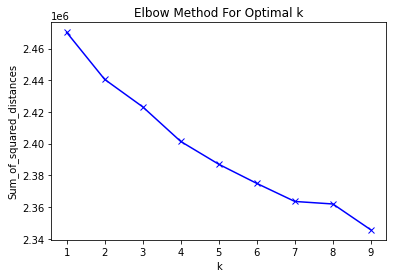

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(DocTerm_abstract)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



*   **Remarque**

La courbe elbow ne nous montre pas l'existence d'un coude.

Nous avons testé plusieurs valeurs de k, et nous trouvons que k=4 donne des résultats plus significatifs. 

In [ ]:
km = KMeans(n_clusters=4, max_iter=100, n_init=5,random_state=0)
km = km.fit(DocTerm_abstract)


In [ ]:
labels= km.labels_

In [ ]:
cluster_center=km.cluster_centers_

In [ ]:
# à quel point les clusters sont éloignés les uns les autres 
silhouette_score = metrics.silhouette_score(DocTerm_abstract, labels, metric='euclidean')
silhouette_score

0.04691681097940871

* Ce score indique que nos clusters sont relativement très proches les uns des autres.

In [ ]:
# assigner un cluster à chaque abstract ( sorte de label)
DF['Bow Clus Label'] = labels  # la dernière colonne du DF représente le numéro du label 
DF.head()

,Pub_Venue,Year,Authors,Title,Index,Id,Abstract,splitted_authors,Bow Clus Label
0,DAC,1988,"['Chung-Kuan Cheng', 'David N. Deutsch']",Improved Channel Routing by Via Minimization a...,131751,"['133716', '133521', '134343']",channel routing area improvement mean via mini...,"[chung-kuan cheng, david n. deutsch]",2
1,DAC,2006,"['Lei Cheng', 'Liang Deng', 'Deming Chen', 'Ma...",A fast simultaneous input vector generation an...,131752,"['132550', '530568', '436486', '134259', '2830...",input vector control ivc technique observation...,"[lei cheng, liang deng, deming chen, martin d....",2
2,DAC,1992,"['Kwang-Ting Cheng', 'Hi-Keung Tony Ma']",On the Over-Specification Problem in Sequentia...,131756,"['455537', '1078626', '131745']",author atpg automatic test pattern generation ...,"[kwang-ting cheng, hi-keung tony ma]",2
3,DAC,2005,"['Lerong Cheng', 'Phoebe Wong', 'Fei Li', 'Yan...",Device and architecture co-optimization for FP...,131759,"['214244', '215701', '214503', '282575', '2144...",device optimization considering supply voltage...,"[lerong cheng, phoebe wong, fei li, yan lin, l...",2
4,DAC,1989,"['Wu-Tung Cheng', 'Meng-Lin Yu']",Differential Fault Simulation - a Fast Method ...,131760,"['131744', '806030']",fast fault simulator called differential fault...,"[wu-tung cheng, meng-lin yu]",2


## Evaluation des résultats du clustering 

*  **visualiser la distribution des articles à travers les 4 clusters**

In [ ]:
# Combien d'articles appartiennent à chaque cluster
DF.groupby(['Bow Clus Label'])['Title'].count()


Bow Clus Label
0      583
1      852
2    13415
3     2783
Name: Title, dtype: int64

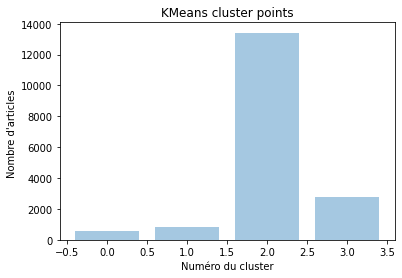

In [ ]:
#visualiser comment les articles sont distribués à travers les 4 clusters 

plt.bar([x for x in range(4)], DF.groupby(['Bow Clus Label'])['Abstract'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Numéro du cluster")
plt.ylabel("Nombre d'articles ")
plt.show()

   **Remarque**
   * On remarque que le cluster n° 2 contient presque la totalité des articles (13415), suivi du cluster n°3, ensuite le cluster n°1, et pour finir le cluster n°0. 

*    **Affichage de TOP 10 des termes présents dans chaque cluster**

In [ ]:
# Trouver le top 10 termes présents dans chaque cluster
print("Top 10 des termes pour chaque cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top 10 des termes pour chaque cluster:
Cluster 0: graph
 vertex
 number
 edge
 result
 time
 class
 tree
 algorithm
 maximum
Cluster 1: network
 node
 result
 protocol
 scheme
 sensor
 wireless
 data
 performance
 communication
Cluster 2: result
 system
 design
 technique
 time
 performance
 circuit
 algorithm
 number
 function
Cluster 3: system
 data
 query
 database
 application
 information
 result
 technique
 user
 performance


**Remarque**

*  On peut dégager qu'il existe une thématique propre à chacun de nos clusters

Cluster 0: Théorie des graphes

Cluster 1: Réseaux et protocoles de communication

Cluster 2: Algorithmique

Cluster 3: Bases de données


*    **Distribution des clusters par revue**

In [ ]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().head(30)

Pub_Venue                          Bow Clus Label
DAC                                0                    8
                                   1                   47
                                   2                 1817
                                   3                  159
DAGM-Symposium                     2                   63
                                   3                    5
DATA BASE                          1                    2
                                   2                  132
                                   3                   80
Data Min. Knowl. Discov.           0                    2
                                   1                    7
                                   2                   86
                                   3                   86
Des. Codes Cryptography            0                   12
                                   1                    3
                                   2                  628
                      

In [ ]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().tail(30)

Pub_Venue                        Bow Clus Label
IJCAI                            0                   13
                                 1                   52
                                 2                 1640
                                 3                  200
IJCAI (1)                        1                    2
                                 2                   75
                                 3                    6
Journal of Systems and Software  0                    5
                                 1                   68
                                 2                  581
                                 3                  262
Knowl. Inf. Syst.                1                    1
                                 2                   35
                                 3                   33
SIGMOD Conference                0                   30
                                 1                   34
                                 2                  556


**Remarque:**

* On remarque que pour chaque revue, on trouve la majorité des articles lui appartenant dans un seul des 4 clusters (hormis les erreurs de classification), ce qui pourrait indiquer que la classification s'est basée sur les revues.

*  **Fréquence d'apparition de chaque revue par cluster**

In [ ]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().head(50)

Bow Clus Label  Pub_Venue                        
0               DAC                                     8
                Data Min. Knowl. Discov.                2
                Des. Codes Cryptography                12
                Discrete Applied Mathematics          417
                Distributed Computing                   5
                Electr. Notes Theor. Comput. Sci.      44
                GECCO                                  11
                GECCO (Companion)                       2
                ICC                                     2
                ICCAD                                   7
                ICCBR                                   1
                ICCSA (1)                               1
                ICCSA (3)                               1
                ICCV                                    1
                ICIP                                    4
                IJCAI                                  13
                Journa

In [ ]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().tail(60)

Bow Clus Label  Pub_Venue                        
1               SIGMOD Conference                      34
                SIGMOD Record                          15
                SMC                                    26
                STOC                                    2
2               DAC                                  1817
                DAGM-Symposium                         63
                DATA BASE                             132
                Data Min. Knowl. Discov.               86
                Des. Codes Cryptography               628
                Discrete Applied Mathematics          862
                Distributed Computing                 156
                Electr. Notes Theor. Comput. Sci.    1597
                GECCO                                1293
                GECCO (Companion)                     229
                GECCO Workshops                        60
                ICC                                   240
                ICCAD 

**Remarque:**

Ici, nous cherchons à savoir quelles sont les revues qui ont le plus d'articles dans chaque cluster afin d'identifier le thème de ce dernier :

cluster 0: la revue majoritaire est Discrete applied Mathematics 417

cluster 1: ICC 301

cluster 2: DAC et IJCAI

cluster 3 : SIGMOD Conference 1007

On voit que la répartition des revues dans chaque cluster correspond bien à ce qu'on a observé lors de l'analyse des termes les plus fréquents dans chaque cluster.

On pourrait déduire que la similarité des éléments dans chaque cluster est basée sur les revues.

On peut aussi noter que le fait que le cluster 2 contienne beaucoup plus d'éléments que les autres clusters peut être justifié par la multitude d'articles publiés dans les revues majoritaires du cluster 2 (>1500 articles), contrairement aux revues d'autres clusters qui sont de l'ordre de quelques centaines.

Pour s'assurer de cela, on continue notre analyse sur les autres variables.

*    **Fréquence d'apparition des années de publication d'articles par cluster**

In [ ]:
DF.groupby(['Bow Clus Label','Year'])['Year'].count().head(60)

Bow Clus Label  Year
0               1971      1
                1975      1
                1981      1
                1983      1
                1985      3
                1986      1
                1989      2
                1990      3
                1991      2
                1993      1
                1995      3
                1996      2
                1997      1
                1998      2
                1999      6
                2000      4
                2001      8
                2002     19
                2003     62
                2004     46
                2005     43
                2006     39
                2007     78
                2008     88
                2009    136
                2010     30
1               1971      1
                1973      2
                1975      4
                1982      1
                1983      5
                1984      2
                1985      1
                1987      3
                1988      2

In [ ]:
DF.groupby(['Bow Clus Label','Year'])['Year'].count().tail(60)

Bow Clus Label  Year
2               1989     256
                1990     103
                1991     136
                1992     151
                1993     137
                1994     143
                1995     326
                1996     169
                1997     320
                1998     186
                1999     375
                2000     214
                2001     410
                2002     399
                2003    1023
                2004     581
                2005    1389
                2006     943
                2007    1499
                2008    1288
                2009    2383
                2010     151
3               1969       4
                1971       3
                1975      19
                1976       8
                1977      16
                1978       7
                1979      10
                1980      10
                1981      20
                1982      22
                1983      24
                1984  

**Remarque**

Nous remarquons que dans tous les clusters, les années les plus significatives (ou productives) sont les années 2000, et principalement entre 2007 et 2010.

On peut donc exclure l'influence des années de publication sur la formation des clusters.

# Kmeans sur la matrice TF-IDF

## Déterminer le nombre de clusters optimal en utilisant la méthode Elbow

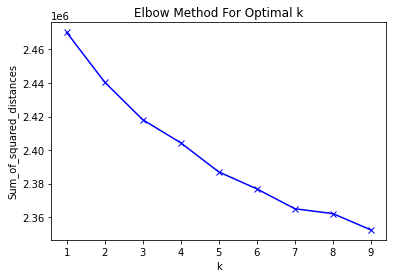

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(DocTerm_abstract)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Remarque**

*   On voit que la courbe générée par la méthode elbow ne nous permet pas d'identifier réellement un coude.
* Dans la suite des expérimentations on remarque que k=4 donne les meilleurs résultats

In [ ]:
km = KMeans(n_clusters=4, max_iter=100, n_init=5,random_state=0)
km = km.fit(TFIDF_abstract)



In [ ]:
labels= km.labels_

In [ ]:
# récupérer les centroides des clusters 
cluster_center=km.cluster_centers_

In [ ]:
# à quel point les clusters sont éloignés les uns les autres 
silhouette_score = metrics.silhouette_score(TFIDF_abstract, labels, metric='euclidean')
silhouette_score

0.00370751743027716

Ce score montre que les clusters sont très proches les uns des autres

In [ ]:
# assigner un cluster à chaque abstract ( sorte de label)
DF['Bow Clus Label'] = labels  # la dernière colonne du DF représente le numéro du label 
DF.head(2)

,Pub_Venue,Year,Authors,Title,Index,Id,Abstract,splitted_authors,Bow Clus Label
0,DAC,1988,"['Chung-Kuan Cheng', 'David N. Deutsch']",Improved Channel Routing by Via Minimization a...,131751,"['133716', '133521', '134343']",channel routing area improvement mean via mini...,"[chung-kuan cheng, david n. deutsch]",0
1,DAC,2006,"['Lei Cheng', 'Liang Deng', 'Deming Chen', 'Ma...",A fast simultaneous input vector generation an...,131752,"['132550', '530568', '436486', '134259', '2830...",input vector control ivc technique observation...,"[lei cheng, liang deng, deming chen, martin d....",0


## Evaluation des résultats du clustering 

*  **visualiser la distribution des articles à travers les 4 clusters**

In [ ]:
# Combien d'articles appartiennent à chaque cluster
DF.groupby(['Bow Clus Label'])['Title'].count()


Bow Clus Label
0     2762
1    12201
2      782
3     1888
Name: Title, dtype: int64

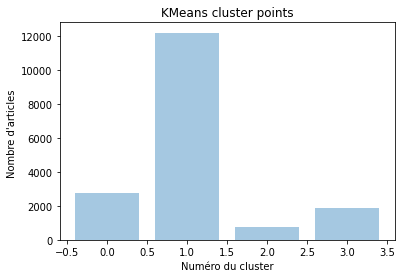

In [ ]:
#visualiser comment les articles sont distribués à travers les 4 clusters 

plt.bar([x for x in range(4)], DF.groupby(['Bow Clus Label'])['Abstract'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Numéro du cluster")
plt.ylabel("Nombre d'articles ")
plt.show()

**On remarque encore une fois que l'un des clusters (ici le 1) contient beaucoup plus d'élément que les autres clusters.**

*    **Affichage de TOP 10 des termes présents dans chaque cluster**

In [ ]:
# Trouver le top 10 termes présents dans chaque cluster
print("Top 10 des termes pour chaque cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = TFIDF_vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top 10 des termes pour chaque cluster:
Cluster 0: circuit
 design
 power
 delay
 test
 technique
 timing
 simulation
 fault
 synthesis
Cluster 1: system
 result
 network
 image
 function
 algorithm
 problem
 time
 technique
 application
Cluster 2: graph
 vertex
 edge
 number
 tree
 maximum
 minimum
 every
 class
 connected
Cluster 3: data
 query
 database
 system
 relational
 application
 user
 information
 xml
 processing



**Résultats** 

On a 4 clusters avec un champs lexical différent pour chacun. 

Pour le cluster n°0: On pourrait comprendre que les articles le contituant parlent de réseaux, d'électronique et de simulation

Pour le cluster n°1: On pourrait comprendre que les articles le contituant parlent de problèmes d'algorithmique et d'informatique théorique. 

Pour le cluster n°2: On pourrait comprendre que les articles le contituant parlent de théorie des graphes 

Pour le cluster n°3: On pourrait comprendre que les articles le contituant parlent de données, bases de données .. etc 

* **Distribution des clusters par revue**

In [ ]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().head(30)

Pub_Venue                          Bow Clus Label
DAC                                0                    8
                                   1                   47
                                   2                 1817
                                   3                  159
DAGM-Symposium                     2                   63
                                   3                    5
DATA BASE                          1                    2
                                   2                  132
                                   3                   80
Data Min. Knowl. Discov.           0                    2
                                   1                    7
                                   2                   86
                                   3                   86
Des. Codes Cryptography            0                   12
                                   1                    3
                                   2                  628
                      

**Remarque:**

* On remarque ici aussi que pour chaque revue, on trouve la majorité des articles lui appartenant dans un seul des 4 clusters (hormis les erreurs de classification), ce qui pourrait indiquer que la classification se base toujours sur les revues.

* **Fréquence d'apparition de chaque revue par cluster**

In [ ]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().head(60)

Bow Clus Label  Pub_Venue                        
0               DAC                                  1338
                DATA BASE                               7
                Des. Codes Cryptography                11
                Discrete Applied Mathematics            6
                Distributed Computing                   4
                Electr. Notes Theor. Comput. Sci.      38
                GECCO                                  26
                GECCO (Companion)                       5
                GECCO Workshops                         3
                ICC                                    35
                ICCAD                                1215
                ICCBR                                   1
                ICCSA (1)                               1
                ICCSA (2)                               4
                ICCSA (3)                               2
                ICIP                                    4
                IJCAI 

In [ ]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().tail(50)

Bow Clus Label  Pub_Venue                        
1               SIGMOD Conference                     461
                SIGMOD Record                         223
                SMC                                   305
                STOC                                   54
2               DAC                                    18
                Data Min. Knowl. Discov.                2
                Des. Codes Cryptography                19
                Discrete Applied Mathematics          550
                Distributed Computing                   9
                Electr. Notes Theor. Comput. Sci.      54
                GECCO                                  25
                GECCO (Companion)                       2
                ICC                                     4
                ICCAD                                  12
                ICCBR                                   1
                ICCSA (1)                               1
                ICCSA 

**Remarque:**

On identifie les revues qui ont le plus d'articles dans chaque cluster :

cluster 0: la revue majoritaire est DAC et ICCAD

cluster 1: IJCAI et Electr. Notes Theor. Comput. Sci.   

cluster 2: Discrete applied Mathematics 

cluster 3 : SIGMOD Conference 1134

On voit que la répartition des revues dans chaque cluster correspond bien à ce qu'on a observé lors de l'analyse des termes les plus fréquents dans chaque cluster.

On pourrait déduire que la similarité des éléments dans chaque cluster est basée sur les revues et sur les thématiques qu'elles abordent.

nous avons noté également que le kmeans appliqué à la matrice TF-IDF arrive à mieux classifier les articles par revues selon le thème abordé. Par exemple, la revue DAC qui traite l'automatique appartient bien au cluster 0 correspondant, contrairement aux résultats avec la matrice BOW qui l'avait classifiée dans le cluster qui aborde le thème d'IA et informatique théorique.


Nous allons tout de même nous pencher sur d'autres pistes d'analyse dans ce qui suit.

*   **Fréquence d'apparition des années de publication par cluster**

In [ ]:
DF.groupby(['Bow Clus Label','Year'])['Year'].count().head(60)

Bow Clus Label  Year
0               1971      1
                1975      1
                1981      1
                1983      1
                1985      3
                1986      1
                1989      2
                1990      3
                1991      2
                1993      1
                1995      3
                1996      2
                1997      1
                1998      2
                1999      6
                2000      4
                2001      8
                2002     19
                2003     62
                2004     46
                2005     43
                2006     39
                2007     78
                2008     88
                2009    136
                2010     30
1               1971      1
                1973      2
                1975      4
                1982      1
                1983      5
                1984      2
                1985      1
                1987      3
                1988      2

Même remarque que pour BOW, les années les plus significatives (ou productives) sont les années 2000, et principalement entre 2007 et 2010. Cela n'influence en rien la formation de clusters.

# Spherical Kmeans

In [ ]:
Skm = SphericalKmeans(n_clusters=4, max_iter=20, n_init=3,random_state=0)
Skmean = Skm.fit(DocTerm_abstract)

 == New init == 
iteration: 0
3342.004612143187
iteration: 1
3636.679134602964
iteration: 2
3777.8810398120377
iteration: 3
3832.709263070593
iteration: 4
3869.3658877035714
iteration: 5
3917.849322040385
iteration: 6
3949.097071751213
iteration: 7
3965.0802048898304
iteration: 8
3974.8494520951663
iteration: 9
3979.1794698098247
iteration: 10
3980.6740983326554
iteration: 11
3981.242063041768
iteration: 12
3981.596790170071
iteration: 13
3981.893407680992
iteration: 14
3982.173806511453
iteration: 15
3982.577838127628
iteration: 16
3983.2562442663775
iteration: 17
3984.2208753592595
iteration: 18
3985.504152457129
iteration: 19
3986.8182032796267
 == New init == 
iteration: 0
3343.8603189823652
iteration: 1
3718.22250433097
iteration: 2
3889.3922719462253
iteration: 3
3931.1762816878054
iteration: 4
3945.6958320426616
iteration: 5
3955.3160550526704
iteration: 6
3964.6616711319393
iteration: 7
3972.8166035347963
iteration: 8
3979.050572278813
iteration: 9
3983.4341984888906
iteration:

In [ ]:
Slabels= Skm.labels_

In [ ]:
# assigner un cluster à chaque abstract ( sorte de label)
DF['Bow Clus Label'] = Slabels  # la dernière colonne du DF représente le numéro du label 
DF.head(2)

,Pub_Venue,Year,Authors,Title,Index,Id,Abstract,Bow Clus Label
0,DAC,1988,"['Chung-Kuan Cheng', 'David N. Deutsch']",Improved Channel Routing by Via Minimization a...,131751,"['133716', '133521', '134343']",channel routing area improvement mean via mini...,1
1,DAC,2006,"['Lei Cheng', 'Liang Deng', 'Deming Chen', 'Ma...",A fast simultaneous input vector generation an...,131752,"['132550', '530568', '436486', '134259', '2830...",input vector control ivc technique observation...,1


In [ ]:
# Combien d'articles appartiennent à chaque cluster
DF.groupby(['Bow Clus Label'])['Title'].count()


Bow Clus Label
0    1945
1    6300
2    5660
3    3728
Name: Title, dtype: int64

In [ ]:
DF.groupby(['Pub_Venue','Bow Clus Label'])['Pub_Venue'].count().head(30)

Pub_Venue                          Bow Clus Label
DAC                                0                   45
                                   1                 1532
                                   2                  390
                                   3                   64
DAGM-Symposium                     0                    1
                                   1                   14
                                   2                    5
                                   3                   48
DATA BASE                          0                    1
                                   1                    3
                                   2                  173
                                   3                   37
Data Min. Knowl. Discov.           0                    3
                                   1                   20
                                   2                   20
                                   3                  138
Des. Codes Cryptograph

On peut noter que l'on trouve toujours que chaque revue est présente majoritairement dans un seul cluster, avec quelques erreurs de classification dans d'autres clusters.

In [ ]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().head(60)

Bow Clus Label  Pub_Venue                        
0               DAC                                    45
                DAGM-Symposium                          1
                DATA BASE                               1
                Data Min. Knowl. Discov.                3
                Des. Codes Cryptography               509
                Discrete Applied Mathematics          938
                Distributed Computing                  23
                Electr. Notes Theor. Comput. Sci.     123
                GECCO                                  43
                GECCO (Companion)                       4
                ICC                                    15
                ICCAD                                  34
                ICCBR                                   2
                ICCSA (1)                               9
                ICCSA (2)                               1
                ICCSA (3)                              11
                ICCV  

In [ ]:
DF.groupby(['Bow Clus Label','Pub_Venue'])['Pub_Venue'].count().tail(50)

Bow Clus Label  Pub_Venue                        
2               Distributed Computing                 123
                Electr. Notes Theor. Comput. Sci.    1579
                GECCO                                 242
                GECCO (Companion)                      62
                GECCO Workshops                        22
                ICC                                   112
                ICCAD                                 140
                ICCBR                                  46
                ICCE                                   49
                ICCSA (1)                              49
                ICCSA (2)                              59
                ICCSA (3)                              45
                ICCV                                    2
                ICIP                                   25
                IJCAI                                1251
                IJCAI (1)                              63
                Journa

**Remarque:**

On identifie les revues qui ont le plus d'articles dans chaque cluster :

cluster 0: la revue majoritaire est Discrete applied Mathematics et Des. Codes Cryptography 
 

cluster 1: DAC et ICCAD


cluster 2: IJCAI et Electr. Notes Theor. Comput. Sci.   


cluster 3 : SIGMOD Conference 

Nous remarquons que le spherical kmeans donne les mêmes résultats que le kmeans sur la matrice TF-IDF en terme de revues et de thèmes abordés dans chaque cluster. On retrouve des résultats presques identiques, avec l'avantage pour spherical kmeans qui donne une répartition plus équilibrée entre clusters en termes de nombre d'articles par clusters.